In [1]:
from deepset import *
MODEL = DeepSet(in_features=3, feats=[80,120,70,50,8], n_class=2,pool="mean") #for full dataset Mean pooling, for small dataset Max pooling
model=MODEL
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device) 


pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean
pool:  mean


In [2]:
import torch
from torch.utils.data import Dataset
import pickle
import os
import numpy as np
import random
import pandas as pd

class StreamingHcaDataset(Dataset): 
    def __init__(self, proton_dir, pion_dir, features=["x", "y", "z"]):
        super().__init__()
        
        self.proton_files = sorted([os.path.join(proton_dir, f) for f in os.listdir(proton_dir) if f.endswith(".pkl")])
        self.pion_files = sorted([os.path.join(pion_dir, f) for f in os.listdir(pion_dir) if f.endswith(".pkl")])

        self.features = features
        self.all_files = self.proton_files + self.pion_files  # Combine file lists
        self.labels = [0] * len(self.proton_files) + [1] * len(self.pion_files)  # 0 for proton, 1 for pion

    def __len__(self):
        return len(self.all_files)  # Total number of files

    def _load_file(self, file_path, label):
        """Loads a single pickle file (containing a single DataFrame) and returns point cloud data with labels."""
        # with open(file_path, "rb") as f:
        #     df = pickle.load(f)  # Load single DataFrame
    
        df=pd.read_pickle(file_path)
        # df=pd.read_parquet(file_path,engine='fastparquet')
        df=df[df["total_energy"]>5]
        
          
        part_feat = df[self.features].to_numpy()

        # Handle NaN and Inf values
        part_feat[np.isnan(part_feat)] = 0.0
        part_feat[np.isinf(part_feat)] = 0.0

        return {
            "part": torch.tensor(part_feat, dtype=torch.float32),
            "label": torch.tensor(label, dtype=torch.long),
            "seq_length": torch.tensor(part_feat.shape[0], dtype=torch.long),
        }

    def __getitem__(self, idx):
        random_idx = random.randint(0, len(self.all_files) - 1)  # Pick a random file
        file_path = self.all_files[random_idx]
        label = self.labels[random_idx]

        return self._load_file(file_path, label)  # Return data from the chosen file


In [3]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    """Custom collate function to handle variable-length point cloud data."""
    parts = [item["part"] for item in batch]  # List of tensors (each of shape [N, 5])
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)  # Convert list to tensor
    seq_lengths = torch.tensor([item["seq_length"] for item in batch], dtype=torch.long)  # Convert list to tensor

    # Pad variable-length tensors to the longest sequence in the batch
    padded_parts = pad_sequence(parts, batch_first=True, padding_value=0.0)  # Shape [batch_size, max_seq_len, 5]

    return {"part": padded_parts, "label": labels, "seq_length": seq_lengths}


In [4]:

energy="10"
granularity="200"
pion_dir =f"/mnt/c/Users/hnayak/Documents/{energy}GeV/small_PKL_pion_{energy}GeV_{granularity}"
proton_dir =f"/mnt/c/Users/hnayak/Documents/{energy}GeV/small_PKL_proton_{energy}GeV_{granularity}"
name=proton_dir.replace(f"/mnt/c/Users/hnayak/Documents/{energy}GeV/small_PKL_proton_","")
print(name)
from torch.utils.data import random_split, DataLoader

# Define dataset
train_dataset = StreamingHcaDataset(proton_dir=proton_dir, pion_dir=pion_dir)

# Define split sizes
total_size = len(train_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # Ensure the sum matches total_size

# Split dataset
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=32)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, collate_fn=collate_fn,num_workers=32)


print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")



10GeV_200
Train: 160000, Validation: 20000, Test: 20000


In [5]:
import tqdm
def test_model(model, test_loader, criterion=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()  # Set model to evaluation mode

    total_loss = 0.0
    correct = 0
    total_samples = 0

    # Progress bar for testing
    test_loader_tqdm = tqdm(enumerate(test_loader), total=len(test_loader), desc="Testing")

    with torch.no_grad():
        for i,batch in test_loader_tqdm:
            parts = batch["part"].to(device)         # Input point cloud data
            labels = batch["label"].to(device)  # Labels
            batch_size,seq_len,feat_dim=parts.shape
            parts=parts.cpu().numpy().reshape(-1,feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts=torch.tensor(parts).reshape(batch_size,seq_len,feat_dim).to(device)

            outputs = model(parts)  # Forward pass
            loss = criterion(outputs, labels) if criterion else 0  # Compute loss if provided
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class prediction
            correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            test_loader_tqdm.set_postfix(loss=loss.item())  # Update progress bar

    avg_loss = total_loss / len(test_loader) if criterion else 0
    accuracy = correct / total_samples * 100

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss , accuracy

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import QuantileTransformer

def train_model(model, train_loader, val_loader, num_epochs=2, learning_rate=5e-4, device=None, save_path=f"./Models/Z_{name}_SP.pth", log_path=f"./Logs/log_summary_Z_{name}_SP.csv"):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float("inf")  # Initialize best loss

    log_data = []  # To store log info for CSV

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, batch in train_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts = parts.cpu().numpy().reshape(-1, feat_dim)
            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts = qt.fit_transform(parts)
            parts = torch.tensor(parts).reshape(batch_size, seq_len, feat_dim).float().to(device)

            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(parts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        val_loss, Accuracy = test_model(model, val_loader, criterion, device)
         

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save log
        log_data.append({
            "Epoch": epoch + 1,
            "Train Loss": avg_train_loss,
            "Val Loss": val_loss,
            "Accuracy": Accuracy,  # Placeholder for accuracy
        })

        # Save model if validation improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with val loss {val_loss:.4f}")

    # Save the log to CSV
    df_log = pd.DataFrame(log_data)
    df_log.to_csv(log_path, index=False)
    print(f"Training log saved to {log_path}")
    print("Training complete!")


In [7]:

if __name__ == "__main__":
    #Train the model
    train_model(model, train_loader,val_loader=val_loader, num_epochs=60, learning_rate=5e-4, device=device)

Testing: 100%|██████████| 625/625 [00:14<00:00, 44.25it/s, loss=0.672]


Test Loss: 0.5543, Accuracy: 71.78%
Epoch [1/60], Train Loss: 0.5673, Val Loss: 0.5543
Model saved at epoch 1 with val loss 0.5543


Testing: 100%|██████████| 625/625 [00:12<00:00, 50.26it/s, loss=0.513]


Test Loss: 0.5374, Accuracy: 72.61%
Epoch [2/60], Train Loss: 0.5435, Val Loss: 0.5374
Model saved at epoch 2 with val loss 0.5374


Testing: 100%|██████████| 625/625 [00:12<00:00, 48.66it/s, loss=0.574]

Test Loss: 0.5407, Accuracy: 72.78%
Epoch [3/60], Train Loss: 0.5370, Val Loss: 0.5407



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.90it/s, loss=0.532]

Test Loss: 0.5493, Accuracy: 71.87%
Epoch [4/60], Train Loss: 0.5330, Val Loss: 0.5493



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.10it/s, loss=0.409]


Test Loss: 0.5331, Accuracy: 73.16%
Epoch [5/60], Train Loss: 0.5291, Val Loss: 0.5331
Model saved at epoch 5 with val loss 0.5331


Testing: 100%|██████████| 625/625 [00:12<00:00, 48.70it/s, loss=0.411]


Test Loss: 0.5235, Accuracy: 74.00%
Epoch [6/60], Train Loss: 0.5278, Val Loss: 0.5235
Model saved at epoch 6 with val loss 0.5235


Testing: 100%|██████████| 625/625 [00:13<00:00, 47.34it/s, loss=0.316]


Test Loss: 0.5203, Accuracy: 74.15%
Epoch [7/60], Train Loss: 0.5264, Val Loss: 0.5203
Model saved at epoch 7 with val loss 0.5203


Testing: 100%|██████████| 625/625 [00:13<00:00, 47.90it/s, loss=0.408]


Test Loss: 0.5167, Accuracy: 74.23%
Epoch [8/60], Train Loss: 0.5255, Val Loss: 0.5167
Model saved at epoch 8 with val loss 0.5167


Testing: 100%|██████████| 625/625 [00:13<00:00, 47.41it/s, loss=0.448]

Test Loss: 0.5181, Accuracy: 73.99%
Epoch [9/60], Train Loss: 0.5235, Val Loss: 0.5181



Testing: 100%|██████████| 625/625 [00:13<00:00, 47.35it/s, loss=0.736]

Test Loss: 0.5280, Accuracy: 73.37%
Epoch [10/60], Train Loss: 0.5207, Val Loss: 0.5280



Testing: 100%|██████████| 625/625 [00:13<00:00, 47.01it/s, loss=0.531]

Test Loss: 0.5195, Accuracy: 73.82%
Epoch [11/60], Train Loss: 0.5214, Val Loss: 0.5195



Testing: 100%|██████████| 625/625 [00:13<00:00, 47.99it/s, loss=0.592]

Test Loss: 0.5219, Accuracy: 73.62%
Epoch [12/60], Train Loss: 0.5213, Val Loss: 0.5219



Testing: 100%|██████████| 625/625 [00:13<00:00, 47.24it/s, loss=0.532]


Test Loss: 0.5148, Accuracy: 73.94%
Epoch [13/60], Train Loss: 0.5228, Val Loss: 0.5148
Model saved at epoch 13 with val loss 0.5148


Testing: 100%|██████████| 625/625 [00:13<00:00, 46.98it/s, loss=0.415]

Test Loss: 0.5159, Accuracy: 73.89%
Epoch [14/60], Train Loss: 0.5205, Val Loss: 0.5159



Testing: 100%|██████████| 625/625 [00:11<00:00, 54.76it/s, loss=0.683]

Test Loss: 0.5255, Accuracy: 73.59%
Epoch [15/60], Train Loss: 0.5216, Val Loss: 0.5255



Testing: 100%|██████████| 625/625 [00:12<00:00, 48.14it/s, loss=0.445]

Test Loss: 0.5223, Accuracy: 73.48%
Epoch [16/60], Train Loss: 0.5199, Val Loss: 0.5223



Testing: 100%|██████████| 625/625 [00:13<00:00, 47.42it/s, loss=0.529]

Test Loss: 0.5203, Accuracy: 73.45%
Epoch [17/60], Train Loss: 0.5217, Val Loss: 0.5203



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.69it/s, loss=0.483]

Test Loss: 0.5169, Accuracy: 74.00%
Epoch [18/60], Train Loss: 0.5197, Val Loss: 0.5169



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.31it/s, loss=0.567]


Test Loss: 0.5175, Accuracy: 73.97%
Epoch [19/60], Train Loss: 0.5194, Val Loss: 0.5175


Testing: 100%|██████████| 625/625 [00:11<00:00, 52.87it/s, loss=0.525]

Test Loss: 0.5187, Accuracy: 73.51%
Epoch [20/60], Train Loss: 0.5189, Val Loss: 0.5187



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.99it/s, loss=0.432]

Test Loss: 0.5157, Accuracy: 74.15%
Epoch [21/60], Train Loss: 0.5181, Val Loss: 0.5157



Testing: 100%|██████████| 625/625 [00:11<00:00, 54.26it/s, loss=0.51] 


Test Loss: 0.5130, Accuracy: 74.20%
Epoch [22/60], Train Loss: 0.5163, Val Loss: 0.5130
Model saved at epoch 22 with val loss 0.5130


Testing: 100%|██████████| 625/625 [00:11<00:00, 53.50it/s, loss=0.523]

Test Loss: 0.5244, Accuracy: 73.60%
Epoch [23/60], Train Loss: 0.5159, Val Loss: 0.5244



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.89it/s, loss=0.385]


Test Loss: 0.5059, Accuracy: 74.39%
Epoch [24/60], Train Loss: 0.5156, Val Loss: 0.5059
Model saved at epoch 24 with val loss 0.5059


Testing: 100%|██████████| 625/625 [00:11<00:00, 55.35it/s, loss=0.641]

Test Loss: 0.5151, Accuracy: 73.98%
Epoch [25/60], Train Loss: 0.5169, Val Loss: 0.5151



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.30it/s, loss=0.449]

Test Loss: 0.5230, Accuracy: 73.46%
Epoch [26/60], Train Loss: 0.5160, Val Loss: 0.5230



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.57it/s, loss=0.47] 


Test Loss: 0.5150, Accuracy: 74.09%
Epoch [27/60], Train Loss: 0.5158, Val Loss: 0.5150


Testing: 100%|██████████| 625/625 [00:11<00:00, 52.76it/s, loss=0.475]

Test Loss: 0.5200, Accuracy: 73.78%
Epoch [28/60], Train Loss: 0.5146, Val Loss: 0.5200



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.91it/s, loss=0.597]

Test Loss: 0.5145, Accuracy: 73.63%
Epoch [29/60], Train Loss: 0.5151, Val Loss: 0.5145



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.32it/s, loss=0.592]

Test Loss: 0.5192, Accuracy: 73.80%
Epoch [30/60], Train Loss: 0.5136, Val Loss: 0.5192



Testing: 100%|██████████| 625/625 [00:11<00:00, 55.14it/s, loss=0.575]

Test Loss: 0.5163, Accuracy: 73.81%
Epoch [31/60], Train Loss: 0.5146, Val Loss: 0.5163



Testing: 100%|██████████| 625/625 [00:11<00:00, 54.92it/s, loss=0.565]

Test Loss: 0.5083, Accuracy: 74.56%
Epoch [32/60], Train Loss: 0.5131, Val Loss: 0.5083



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.59it/s, loss=0.576]

Test Loss: 0.5109, Accuracy: 74.65%
Epoch [33/60], Train Loss: 0.5143, Val Loss: 0.5109



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.67it/s, loss=0.646]

Test Loss: 0.5117, Accuracy: 74.16%
Epoch [34/60], Train Loss: 0.5125, Val Loss: 0.5117



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.42it/s, loss=0.444]

Test Loss: 0.5084, Accuracy: 74.55%
Epoch [35/60], Train Loss: 0.5142, Val Loss: 0.5084



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.52it/s, loss=0.411]

Test Loss: 0.5052, Accuracy: 74.69%
Epoch [36/60], Train Loss: 0.5134, Val Loss: 0.5052
Model saved at epoch 36 with val loss 0.5052



Testing: 100%|██████████| 625/625 [00:12<00:00, 51.52it/s, loss=0.509]

Test Loss: 0.5107, Accuracy: 74.58%
Epoch [37/60], Train Loss: 0.5117, Val Loss: 0.5107



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.11it/s, loss=0.568]

Test Loss: 0.5078, Accuracy: 74.32%
Epoch [38/60], Train Loss: 0.5133, Val Loss: 0.5078



Testing: 100%|██████████| 625/625 [00:11<00:00, 54.80it/s, loss=0.495]

Test Loss: 0.5111, Accuracy: 74.12%
Epoch [39/60], Train Loss: 0.5098, Val Loss: 0.5111



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.27it/s, loss=0.529]

Test Loss: 0.5124, Accuracy: 74.15%
Epoch [40/60], Train Loss: 0.5118, Val Loss: 0.5124



Testing: 100%|██████████| 625/625 [00:12<00:00, 51.75it/s, loss=0.507]


Test Loss: 0.5078, Accuracy: 74.61%
Epoch [41/60], Train Loss: 0.5112, Val Loss: 0.5078


Testing: 100%|██████████| 625/625 [00:11<00:00, 52.61it/s, loss=0.498]

Test Loss: 0.5057, Accuracy: 74.49%
Epoch [42/60], Train Loss: 0.5127, Val Loss: 0.5057



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.70it/s, loss=0.612]

Test Loss: 0.5120, Accuracy: 74.47%
Epoch [43/60], Train Loss: 0.5103, Val Loss: 0.5120



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.53it/s, loss=0.517]

Test Loss: 0.5061, Accuracy: 74.33%
Epoch [44/60], Train Loss: 0.5106, Val Loss: 0.5061



Testing: 100%|██████████| 625/625 [00:12<00:00, 51.93it/s, loss=0.46] 


Test Loss: 0.5094, Accuracy: 74.26%
Epoch [45/60], Train Loss: 0.5119, Val Loss: 0.5094


Testing: 100%|██████████| 625/625 [00:11<00:00, 52.73it/s, loss=0.529]

Test Loss: 0.5087, Accuracy: 74.57%
Epoch [46/60], Train Loss: 0.5114, Val Loss: 0.5087



Testing: 100%|██████████| 625/625 [00:12<00:00, 51.82it/s, loss=0.507]

Test Loss: 0.5039, Accuracy: 74.63%
Epoch [47/60], Train Loss: 0.5092, Val Loss: 0.5039
Model saved at epoch 47 with val loss 0.5039



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.75it/s, loss=0.488]

Test Loss: 0.5068, Accuracy: 74.78%
Epoch [48/60], Train Loss: 0.5089, Val Loss: 0.5068



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.35it/s, loss=0.532]

Test Loss: 0.5107, Accuracy: 74.34%
Epoch [49/60], Train Loss: 0.5115, Val Loss: 0.5107



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.70it/s, loss=0.581]

Test Loss: 0.5138, Accuracy: 74.34%
Epoch [50/60], Train Loss: 0.5086, Val Loss: 0.5138



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.26it/s, loss=0.561]

Test Loss: 0.5092, Accuracy: 74.25%
Epoch [51/60], Train Loss: 0.5096, Val Loss: 0.5092



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.24it/s, loss=0.562]

Test Loss: 0.5189, Accuracy: 73.81%
Epoch [52/60], Train Loss: 0.5103, Val Loss: 0.5189



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.62it/s, loss=0.449]

Test Loss: 0.5094, Accuracy: 74.23%
Epoch [53/60], Train Loss: 0.5079, Val Loss: 0.5094



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.81it/s, loss=0.549]

Test Loss: 0.5042, Accuracy: 74.78%
Epoch [54/60], Train Loss: 0.5088, Val Loss: 0.5042



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.74it/s, loss=0.488]


Test Loss: 0.5035, Accuracy: 75.12%
Epoch [55/60], Train Loss: 0.5081, Val Loss: 0.5035
Model saved at epoch 55 with val loss 0.5035


Testing: 100%|██████████| 625/625 [00:11<00:00, 55.04it/s, loss=0.462]

Test Loss: 0.5056, Accuracy: 74.69%
Epoch [56/60], Train Loss: 0.5082, Val Loss: 0.5056



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.50it/s, loss=0.598]

Test Loss: 0.5045, Accuracy: 74.73%
Epoch [57/60], Train Loss: 0.5064, Val Loss: 0.5045



Testing: 100%|██████████| 625/625 [00:12<00:00, 51.94it/s, loss=0.671]

Test Loss: 0.5104, Accuracy: 73.93%
Epoch [58/60], Train Loss: 0.5067, Val Loss: 0.5104



Testing: 100%|██████████| 625/625 [00:11<00:00, 53.09it/s, loss=0.426]

Test Loss: 0.5129, Accuracy: 74.16%
Epoch [59/60], Train Loss: 0.5085, Val Loss: 0.5129



Testing: 100%|██████████| 625/625 [00:11<00:00, 52.11it/s, loss=0.68] 


Test Loss: 0.5046, Accuracy: 74.78%
Epoch [60/60], Train Loss: 0.5092, Val Loss: 0.5046
Training log saved to ./Logs/log_summary_Z_10GeV_200_SP.csv
Training complete!


In [8]:
model_test = MODEL
model_name=f"./Models/Z_{name}_SP.pth"
print(model_name)
model_test.load_state_dict(torch.load(f"./Models/Z_{name}_SP.pth",weights_only=True))
model_test.to(device)

./Models/Z_10GeV_200_SP.pth


DeepSet(
  (sequential): ModuleList(
    (0): DeepSetLayer(
      (Gamma): Linear(in_features=3, out_features=80, bias=True)
      (Lambda): Linear(in_features=3, out_features=80, bias=True)
      (bn): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (1): LeakyReLU(negative_slope=0.01)
    (2): DeepSetLayer(
      (Gamma): Linear(in_features=80, out_features=120, bias=True)
      (Lambda): Linear(in_features=80, out_features=120, bias=True)
      (bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (3): LeakyReLU(negative_slope=0.01)
    (4): DeepSetLayer(
      (Gamma): Linear(in_features=120, out_features=70, bias=True)
      (Lambda): Linear(in_features=120, out_features=70, bias=True)
      (bn): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
    (5): LeakyReLU(negative_slope=0.01)
    (6): DeepSetLayer(
      (Gamma): Linear(in_features=70, out_features=5

In [9]:
total_params = sum(p.numel() for p in MODEL.parameters())
print(total_params)

44972


In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import beta
from matplotlib.font_manager import FontProperties

bold_font = FontProperties(weight='bold', size=14)

def evaluate_model(model, data_loader, criterion, device, name1="model", return_accuracy=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    data_loader_tqdm = tqdm(enumerate(data_loader), desc="Testing", total=len(data_loader))
    
    true_labels = []
    pred_labels = []
    all_scores = []

    with torch.no_grad():
        for i, batch in data_loader_tqdm:
            parts = batch["part"].to(device)
            batch_size, seq_len, feat_dim = parts.shape
            parts_np = parts.cpu().numpy().reshape(-1, feat_dim)

            qt = QuantileTransformer(output_distribution='normal', random_state=42)
            parts_np = qt.fit_transform(parts_np)
            parts = torch.tensor(parts_np).reshape(batch_size, seq_len, feat_dim).to(device)

            labels = batch["label"].to(device)
            outputs = model(parts)
            preds = F.softmax(outputs, dim=1)

            # Collect soft scores for the positive class (class 1)
            all_scores.extend(preds[:, 1].detach().cpu().numpy())
            pred_labels.extend(torch.argmax(preds, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            if return_accuracy:
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total if return_accuracy else None

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    colors = ["#cce5ff", "#004c99"]
    cmap = LinearSegmentedColormap.from_list("Custom Blue", colors)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Proton", "Pion"], yticklabels=["Proton", "Pion"],
                annot_kws={"size": 18, "weight": "bold"})
    
    TP, FN = cm[0, 0], cm[0, 1]
    FP, TN = cm[1, 0], cm[1, 1]
    n_total = TP + TN + FP + FN
    n_correct = TP + TN
    alpha = 0.32

    lower_bound = beta.ppf(alpha / 2, n_correct, n_total - n_correct + 1)
    upper_bound = beta.ppf(1 - alpha / 2, n_correct + 1, n_total - n_correct)
    
    title = f"Accuracy: {accuracy:.2f}%, 68% CI: [{lower_bound*100:.2f}%, {upper_bound*100:.2f}%]"
    plt.title(title, fontsize=15, weight='bold')
    plt.xlabel('Predicted', size=14, weight='bold')
    plt.ylabel('True', size=14, weight='bold')
    plt.xticks(size=14, weight='bold')
    plt.yticks(size=14, weight='bold')
    print(f"./Plots/confusion_matrix_{name}_SP.pdf")
    plt.savefig(f"./Plots/confusion_matrix_{name}_SP.pdf", dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Confusion Matrix:\n{cm}")
    print(f"68% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

    # ROC Curve
    y_true = np.array(true_labels)
    y_scores = np.array(all_scores)

    np.savez(f"./Scores/scores_{name}_SP.npz", array1=y_true, array2=y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    jscore = tpr - fpr
    j_index = np.argmax(jscore)
    threshold = thresholds[j_index]
    print(f"Optimal Threshold: {threshold:.4f} (J-Index: {j_index})")

    N_x = sum(y_true == 0)
    N_y = sum(y_true == 1)
    sigma_fpr = np.sqrt(fpr * (1 - fpr) / N_x)
    sigma_tpr = np.sqrt(tpr * (1 - tpr) / N_y)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f} )')
    plt.fill_between(fpr, tpr - 5 * sigma_tpr, tpr + 5 * sigma_tpr,
                     color='blue', alpha=0.25, label='1-sigma region (PiPR) [5x]')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate', fontsize=16,weight='bold')
    plt.ylabel('True Positive Rate', fontsize=16,weight='bold')
    plt.xticks(fontsize=14,weight='bold')
    plt.yticks(fontsize=14,weight='bold')
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=17,weight='bold')
    # plt.legend(loc='lower right', fontsize=14, weight='bold')
    plt.legend(title="",prop={'weight': 'bold', 'size': 14},title_fontproperties=bold_font, loc='lower right')
    plt.grid()
    plt.savefig(f"./Plots/roc_curve_{name}_SP.pdf")

    return (avg_loss, f"{accuracy:.2f}%") if return_accuracy else avg_loss



Testing: 100%|██████████| 625/625 [00:11<00:00, 54.56it/s]


./Plots/confusion_matrix_10GeV_200_SP.pdf
Confusion Matrix:
[[7800 2154]
 [2927 7119]]
68% Confidence Interval: [0.7429, 0.7490]
Optimal Threshold: 0.4981 (J-Index: 2995)


(0.5093777537345886, '74.59%')

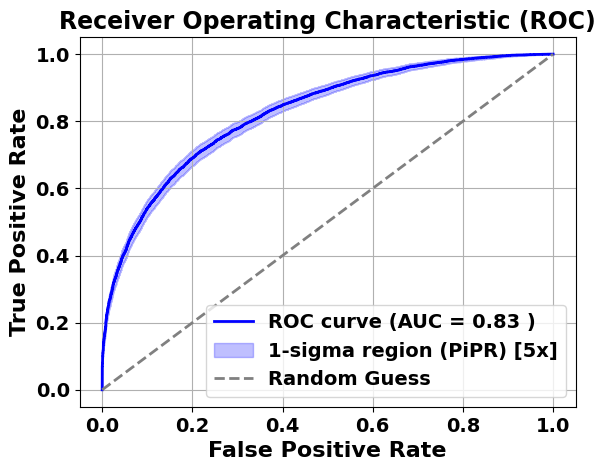

In [11]:
evaluate_model(model_test, test_loader, nn.CrossEntropyLoss(), device, return_accuracy=True)